# *MillGuard* — Predictive maintenance for milling equipment  

### Import Package

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Get Dataset

Dataset Overview

This synthetic dataset simulates the operational behavior of a milling machine. It contains 10,000 observations (rows), each representing a single production instance with 14 features (columns). The data is designed to model realistic process conditions and failure mechanisms.

| Feature                     | Description                                                                                                                                                                                               |
| --------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **UID**                     | Unique identifier ranging from 1 to 10,000.                                                                                                                                                               |
| **Product ID**              | A composite identifier consisting of a quality code (`L`, `M`, or `H`) — representing low (50% of samples), medium (30%), and high (20%) quality variants — followed by a variant-specific serial number. |
| **Type**                    | The product quality type extracted from the Product ID (`L`, `M`, or `H`).                                                                                                                                |
| **Air Temperature [K]**     | Simulated using a random walk process, normalized to a standard deviation of 2 K around a mean of 300 K.                                                                                                  |
| **Process Temperature [K]** | Generated from a random walk process normalized to 1 K standard deviation, added to the air temperature plus 10 K.                                                                                        |
| **Rotational Speed [rpm]**  | Calculated based on a power of 2860 W with additional Gaussian noise.                                                                                                                                     |
| **Torque [Nm]**             | Normally distributed around 40 Nm with a standard deviation of 10 Nm, ensuring no negative values.                                                                                                        |
| **Tool Wear [min]**         | Tool wear increases based on product quality: +2 min for L, +3 min for M, and +5 min for H variants.                                                                                                      |
| **Machine Failure**         | Binary label indicating whether the machine failed during this process (1 = failure, 0 = no failure). Failures arise from one or more of the independent failure modes below.                             |


🔧 Failure Mode Definitions
1. TWF – Tool Wear Failure

The cutting tool or component became too worn.

Often associated with:
- High tool wear [min] values
- High torque
- Long operation time

Interpretation:
The machine still runs, but tool degradation pushes it past the safe operating threshold.

2. HDF – Heat Dissipation Failure

The machine can't dissipate heat adequately.

Typically triggered when:

- Process temperature or air temperature is high
- Cooling system performance degrades

Interpretation:
Thermal stress causes performance issues or shutdowns.

3. PWF – Power Failure

Electrical failure or instability.

Linked with:

- Abnormal power behavior
- Possibly extreme RPM or torque interactions

Interpretation:
The machine loses power or experiences electrical interruption.

4. OSF – Overstrain Failure

Mechanical overload: the machine was pushed beyond safe limits.

Strongly associated with:

- High torque
- High rotational speed
- Excessive load forcing

Interpretation:
Stress exceeds the mechanical capacity → breakdown.

5. RNF – Random Failure

Failure with no identifiable sensor pattern leading up to it.

Not caused by wear, heat, overload, or power.

Interpretation:
Represents unpredictable or unexplainable failure events (noise, defects, random disruptions).

In [2]:
mill_df = pd.read_csv('../dataset/ai4i2020.csv')

In [3]:
mill_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
mill_df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


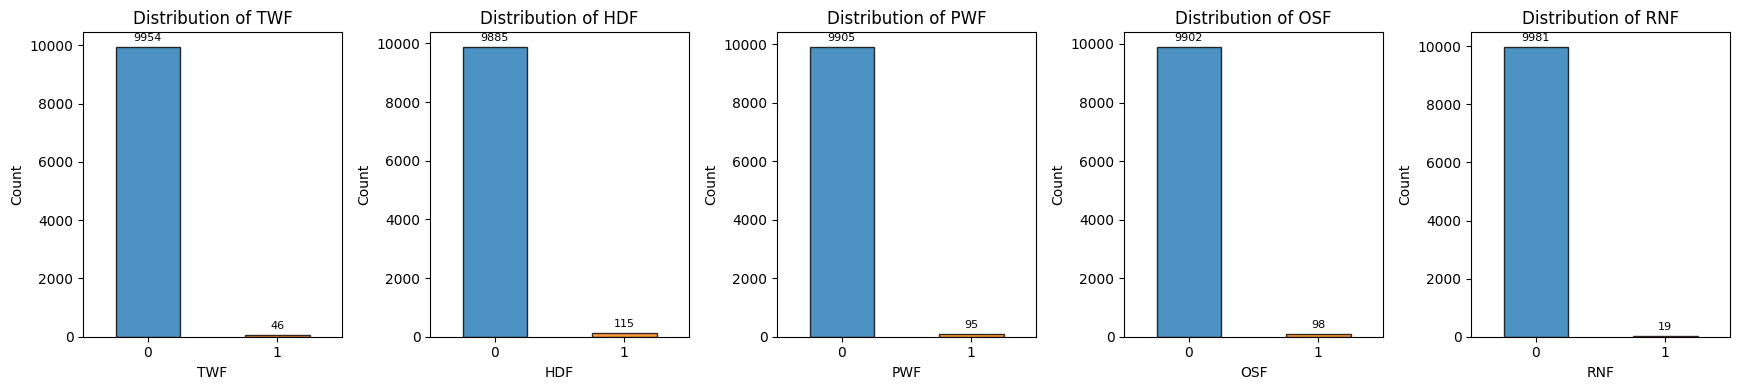

In [30]:
cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

fig2, axs2 = plt.subplots(1, len(cols), figsize=(len(cols) * 3.5, 4))
axs2 = np.atleast_1d(axs2)

for ax_, col in zip(axs2, cols):
    counts = mill_df[col].value_counts().sort_index()
    counts.plot(kind='bar', ax=ax_, color=['C0', 'C1'], edgecolor='black', alpha=0.8)
    ax_.set_title(f'Distribution of {col}')
    ax_.set_xlabel(col)
    ax_.set_ylabel('Count')
    ax_.set_xticklabels([str(int(x)) for x in counts.index], rotation=0)
    for p in ax_.patches:
        ax_.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

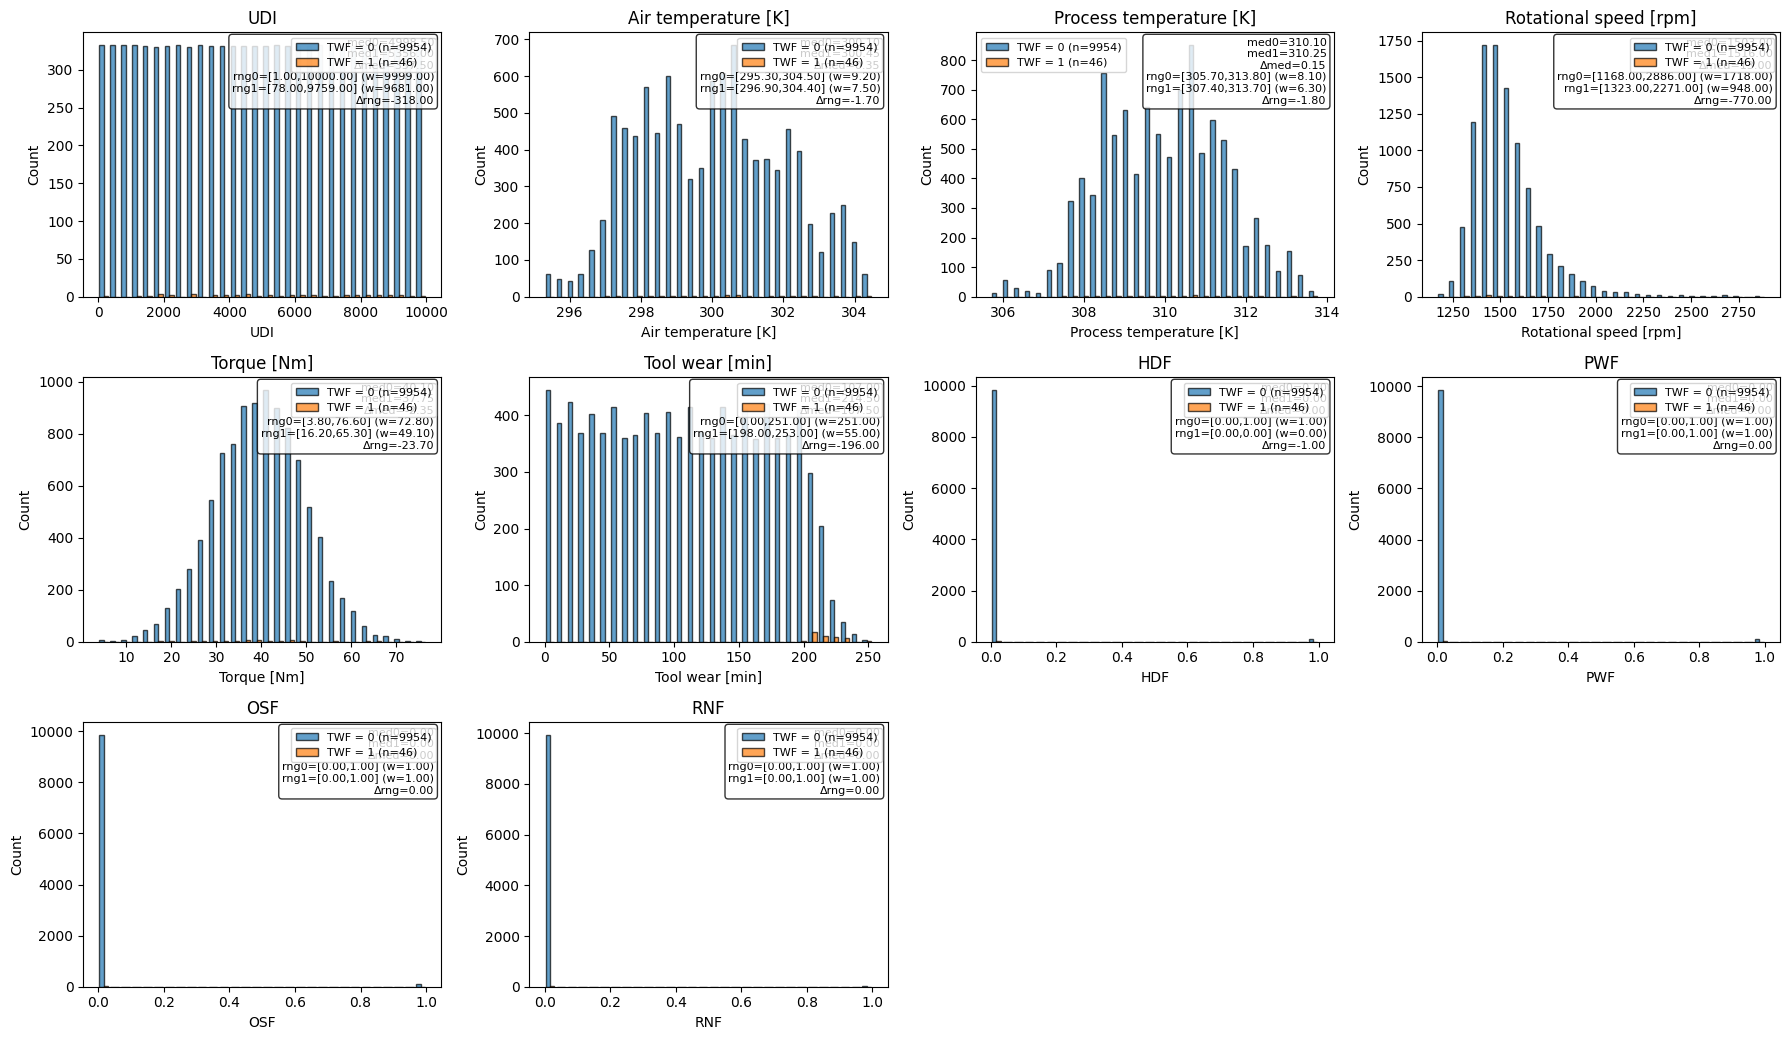

,median_TWF0,median_TWF1,median_diff,range_TWF0,range_TWF1,range_diff,n_TWF0,n_TWF1
feature,,,,,,,,
UDI,4998.5,5356.00,357.50,9999.0,9681.0,-318.0,9954,46
Air temperature [K],300.1,300.45,0.35,9.2,7.5,-1.7,9954,46
Process temperature [K],310.1,310.25,0.15,8.1,6.3,-1.8,9954,46
Rotational speed [rpm],1503.0,1516.00,13.00,1718.0,948.0,-770.0,9954,46
Torque [Nm],40.1,37.75,-2.35,72.8,49.1,-23.7,9954,46
Tool wear [min],107.0,214.50,107.50,251.0,55.0,-196.0,9954,46
HDF,0.0,0.00,0.00,1.0,0.0,-1.0,9954,46
PWF,0.0,0.00,0.00,1.0,1.0,0.0,9954,46
OSF,0.0,0.00,0.00,1.0,1.0,0.0,9954,46


In [32]:
# Plot distributions of all numeric features for TWF == 1 vs TWF == 0
plot_feats = [c for c in numeric_cols if c not in ('TWF', 'Machine failure')]

n_cols = 4
n_rows = int(np.ceil(len(plot_feats) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5))
axs = axs.flatten()

colors = ['C0', 'C1']
labels = ['TWF = 0', 'TWF = 1']

stats = []
for i, feat in enumerate(plot_feats):
    ax_i = axs[i]
    vals = mill_df[feat].dropna()
    bins = np.histogram_bin_edges(vals, bins=30)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    width = (bins[1] - bins[0]) * 0.4

    grp0 = mill_df.loc[mill_df['TWF'] == 0, feat].dropna()
    grp1 = mill_df.loc[mill_df['TWF'] == 1, feat].dropna()

    # plot histograms side-by-side
    for j, (grp, lbl) in enumerate(zip([grp0, grp1], labels)):
        counts, _ = np.histogram(grp, bins=bins)
        x = bin_centers + (j - 0.5) * width
        ax_i.bar(x, counts, width=width, color=colors[j], edgecolor='black', alpha=0.7,
                 label=f'{lbl} (n={len(grp)})')

    # compute medians and ranges and differences
    med0 = grp0.median() if len(grp0) else np.nan
    med1 = grp1.median() if len(grp1) else np.nan
    med_diff = med1 - med0

    min0, max0 = (grp0.min(), grp0.max()) if len(grp0) else (np.nan, np.nan)
    min1, max1 = (grp1.min(), grp1.max()) if len(grp1) else (np.nan, np.nan)
    range0 = max0 - min0
    range1 = max1 - min1
    range_diff = range1 - range0

    stats.append({
        'feature': feat,
        'median_TWF0': med0,
        'median_TWF1': med1,
        'median_diff': med_diff,
        'range_TWF0': range0,
        'range_TWF1': range1,
        'range_diff': range_diff,
        'n_TWF0': len(grp0),
        'n_TWF1': len(grp1),
    })

    # annotate subplot with summary (top-right)
    annot = (f"med0={med0:.2f}\nmed1={med1:.2f}\nΔmed={med_diff:.2f}\n"
             f"rng0=[{min0:.2f},{max0:.2f}] (w={range0:.2f})\n"
             f"rng1=[{min1:.2f},{max1:.2f}] (w={range1:.2f})\nΔrng={range_diff:.2f}")
    ax_i.text(0.98, 0.98, annot, transform=ax_i.transAxes,
              ha='right', va='top', fontsize=8,
              bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    ax_i.set_title(feat)
    ax_i.set_xlabel(feat)
    ax_i.set_ylabel('Count')
    ax_i.legend(fontsize=8)

# turn off any unused axes
for k in range(len(plot_feats), len(axs)):
    axs[k].axis('off')

plt.tight_layout()
plt.show()

# show a concise summary table
stats_df = pd.DataFrame(stats).set_index('feature')
stats_df[['median_TWF0','median_TWF1','median_diff','range_TWF0','range_TWF1','range_diff','n_TWF0','n_TWF1']]

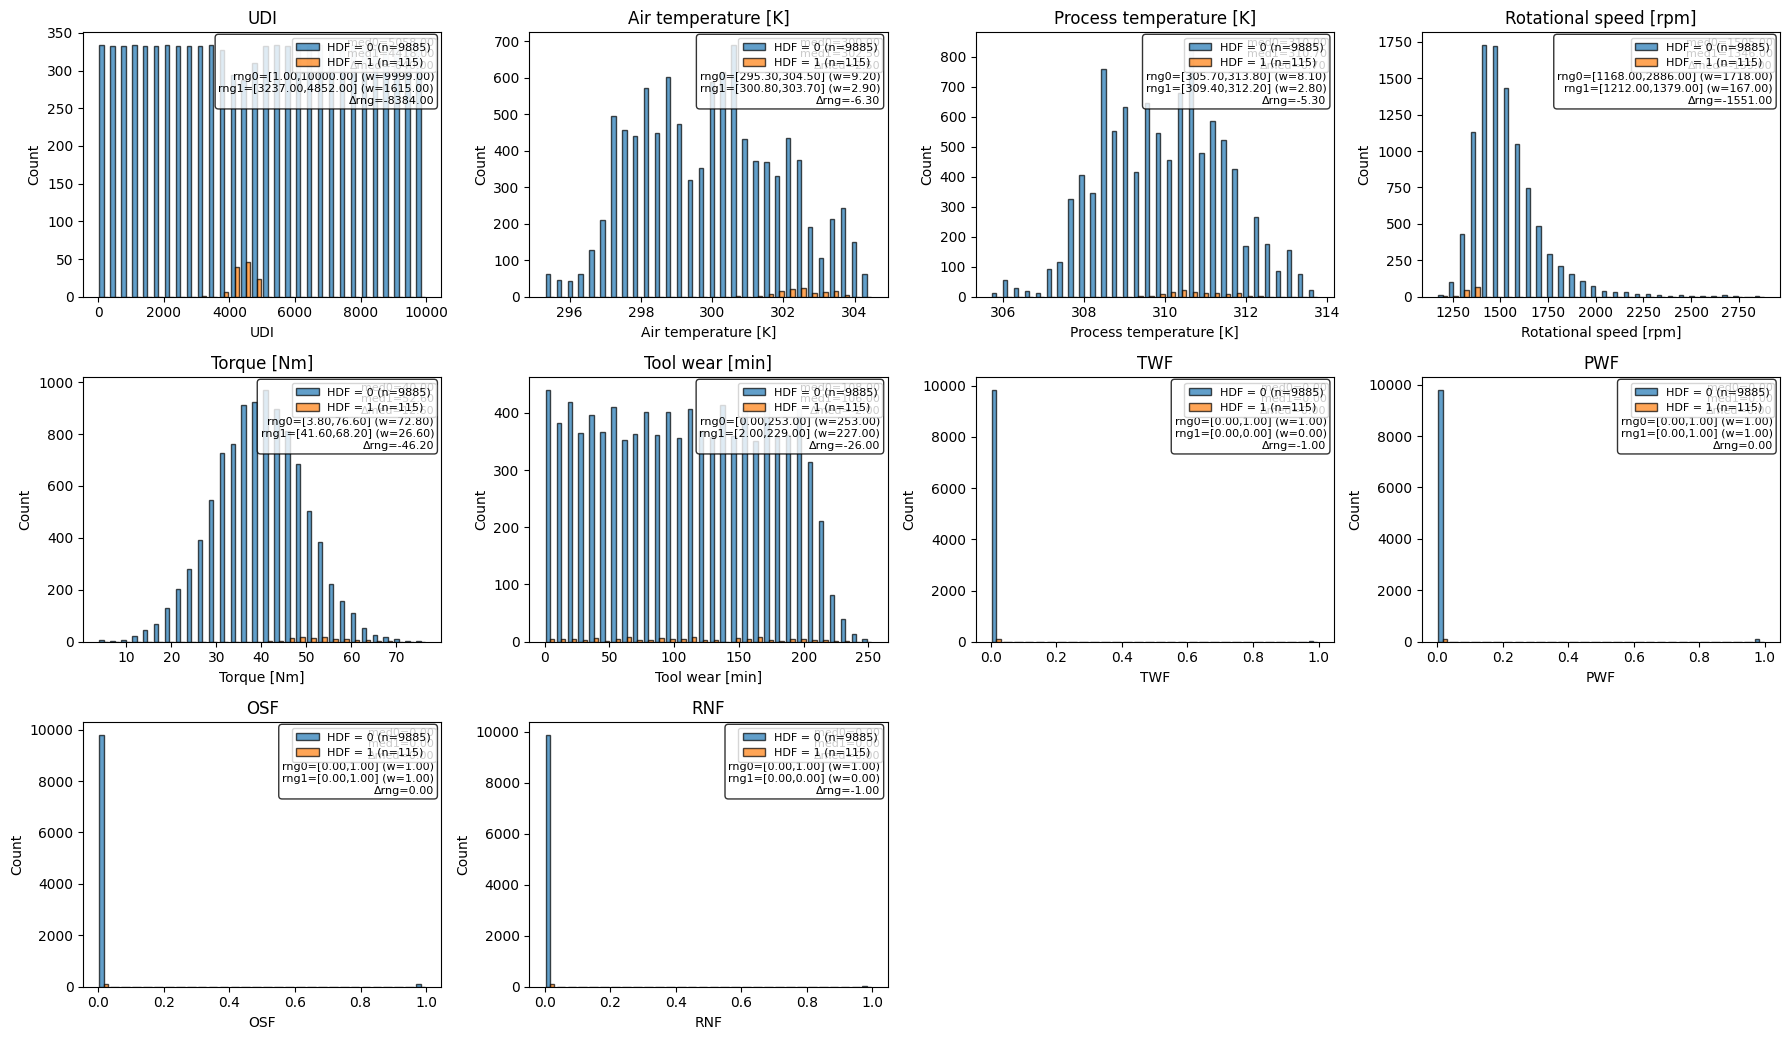

,median_HDF0,median_HDF1,median_diff,range_HDF0,range_HDF1,range_diff,n_HDF0,n_HDF1
feature,,,,,,,,
UDI,5058.0,4418.0,-640.0,9999.0,1615.0,-8384.0,9885,115
Air temperature [K],300.0,302.5,2.5,9.2,2.9,-6.3,9885,115
Process temperature [K],310.0,310.7,0.7,8.1,2.8,-5.3,9885,115
Rotational speed [rpm],1505.0,1346.0,-159.0,1718.0,167.0,-1551.0,9885,115
Torque [Nm],40.0,52.6,12.6,72.8,26.6,-46.2,9885,115
Tool wear [min],108.0,106.0,-2.0,253.0,227.0,-26.0,9885,115
TWF,0.0,0.0,0.0,1.0,0.0,-1.0,9885,115
PWF,0.0,0.0,0.0,1.0,1.0,0.0,9885,115
OSF,0.0,0.0,0.0,1.0,1.0,0.0,9885,115


In [33]:
# Plot distributions of all numeric features for TWF == 1 vs TWF == 0
plot_feats = [c for c in numeric_cols if c not in ('HDF', 'Machine failure')]

n_cols = 4
n_rows = int(np.ceil(len(plot_feats) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5))
axs = axs.flatten()

colors = ['C0', 'C1']
labels = ['HDF = 0', 'HDF = 1']

stats = []
for i, feat in enumerate(plot_feats):
    ax_i = axs[i]
    vals = mill_df[feat].dropna()
    bins = np.histogram_bin_edges(vals, bins=30)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    width = (bins[1] - bins[0]) * 0.4

    grp0 = mill_df.loc[mill_df['HDF'] == 0, feat].dropna()
    grp1 = mill_df.loc[mill_df['HDF'] == 1, feat].dropna()

    # plot histograms side-by-side
    for j, (grp, lbl) in enumerate(zip([grp0, grp1], labels)):
        counts, _ = np.histogram(grp, bins=bins)
        x = bin_centers + (j - 0.5) * width
        ax_i.bar(x, counts, width=width, color=colors[j], edgecolor='black', alpha=0.7,
                 label=f'{lbl} (n={len(grp)})')

    # compute medians and ranges and differences
    med0 = grp0.median() if len(grp0) else np.nan
    med1 = grp1.median() if len(grp1) else np.nan
    med_diff = med1 - med0

    min0, max0 = (grp0.min(), grp0.max()) if len(grp0) else (np.nan, np.nan)
    min1, max1 = (grp1.min(), grp1.max()) if len(grp1) else (np.nan, np.nan)
    range0 = max0 - min0
    range1 = max1 - min1
    range_diff = range1 - range0

    stats.append({
        'feature': feat,
        'median_HDF0': med0,
        'median_HDF1': med1,
        'median_diff': med_diff,
        'range_HDF0': range0,
        'range_HDF1': range1,
        'range_diff': range_diff,
        'n_HDF0': len(grp0),
        'n_HDF1': len(grp1),
    })

    # annotate subplot with summary (top-right)
    annot = (f"med0={med0:.2f}\nmed1={med1:.2f}\nΔmed={med_diff:.2f}\n"
             f"rng0=[{min0:.2f},{max0:.2f}] (w={range0:.2f})\n"
             f"rng1=[{min1:.2f},{max1:.2f}] (w={range1:.2f})\nΔrng={range_diff:.2f}")
    ax_i.text(0.98, 0.98, annot, transform=ax_i.transAxes,
              ha='right', va='top', fontsize=8,
              bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    ax_i.set_title(feat)
    ax_i.set_xlabel(feat)
    ax_i.set_ylabel('Count')
    ax_i.legend(fontsize=8)

# turn off any unused axes
for k in range(len(plot_feats), len(axs)):
    axs[k].axis('off')

plt.tight_layout()
plt.show()

# show a concise summary table
stats_df = pd.DataFrame(stats).set_index('feature')
stats_df[['median_HDF0','median_HDF1','median_diff','range_HDF0','range_HDF1','range_diff','n_HDF0','n_HDF1']]

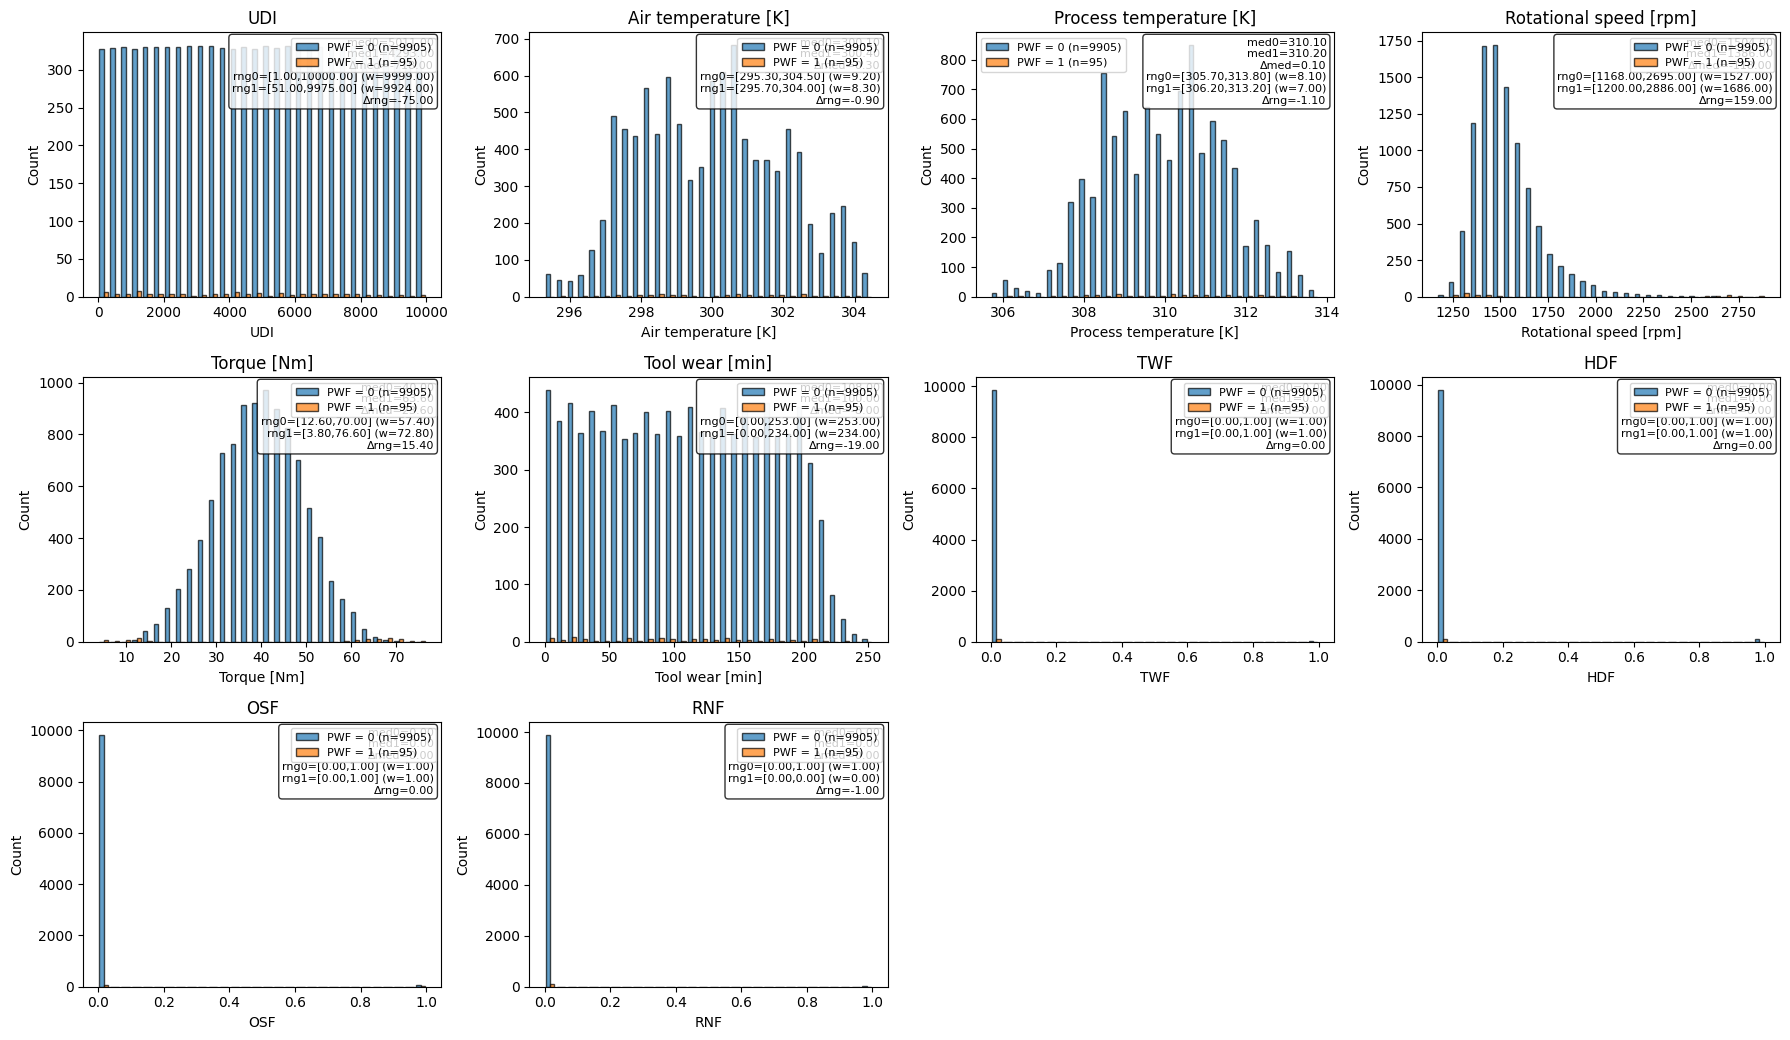

,median_PWF0,median_PWF1,median_diff,range_PWF0,range_PWF1,range_diff,n_PWF0,n_PWF1
feature,,,,,,,,
UDI,5011.0,4293.0,-718.0,9999.0,9924.0,-75.0,9905,95
Air temperature [K],300.1,300.4,0.3,9.2,8.3,-0.9,9905,95
Process temperature [K],310.1,310.2,0.1,8.1,7.0,-1.1,9905,95
Rotational speed [rpm],1504.0,1386.0,-118.0,1527.0,1686.0,159.0,9905,95
Torque [Nm],40.0,63.6,23.6,57.4,72.8,15.4,9905,95
Tool wear [min],108.0,100.0,-8.0,253.0,234.0,-19.0,9905,95
TWF,0.0,0.0,0.0,1.0,1.0,0.0,9905,95
HDF,0.0,0.0,0.0,1.0,1.0,0.0,9905,95
OSF,0.0,0.0,0.0,1.0,1.0,0.0,9905,95


In [34]:
# Plot distributions of all numeric features for TWF == 1 vs TWF == 0
plot_feats = [c for c in numeric_cols if c not in ('PWF', 'Machine failure')]

n_cols = 4
n_rows = int(np.ceil(len(plot_feats) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5))
axs = axs.flatten()

colors = ['C0', 'C1']
labels = ['PWF = 0', 'PWF = 1']

stats = []
for i, feat in enumerate(plot_feats):
    ax_i = axs[i]
    vals = mill_df[feat].dropna()
    bins = np.histogram_bin_edges(vals, bins=30)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    width = (bins[1] - bins[0]) * 0.4

    grp0 = mill_df.loc[mill_df['PWF'] == 0, feat].dropna()
    grp1 = mill_df.loc[mill_df['PWF'] == 1, feat].dropna()

    # plot histograms side-by-side
    for j, (grp, lbl) in enumerate(zip([grp0, grp1], labels)):
        counts, _ = np.histogram(grp, bins=bins)
        x = bin_centers + (j - 0.5) * width
        ax_i.bar(x, counts, width=width, color=colors[j], edgecolor='black', alpha=0.7,
                 label=f'{lbl} (n={len(grp)})')

    # compute medians and ranges and differences
    med0 = grp0.median() if len(grp0) else np.nan
    med1 = grp1.median() if len(grp1) else np.nan
    med_diff = med1 - med0

    min0, max0 = (grp0.min(), grp0.max()) if len(grp0) else (np.nan, np.nan)
    min1, max1 = (grp1.min(), grp1.max()) if len(grp1) else (np.nan, np.nan)
    range0 = max0 - min0
    range1 = max1 - min1
    range_diff = range1 - range0

    stats.append({
        'feature': feat,
        'median_PWF0': med0,
        'median_PWF1': med1,
        'median_diff': med_diff,
        'range_PWF0': range0,
        'range_PWF1': range1,
        'range_diff': range_diff,
        'n_PWF0': len(grp0),
        'n_PWF1': len(grp1),
    })

    # annotate subplot with summary (top-right)
    annot = (f"med0={med0:.2f}\nmed1={med1:.2f}\nΔmed={med_diff:.2f}\n"
             f"rng0=[{min0:.2f},{max0:.2f}] (w={range0:.2f})\n"
             f"rng1=[{min1:.2f},{max1:.2f}] (w={range1:.2f})\nΔrng={range_diff:.2f}")
    ax_i.text(0.98, 0.98, annot, transform=ax_i.transAxes,
              ha='right', va='top', fontsize=8,
              bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    ax_i.set_title(feat)
    ax_i.set_xlabel(feat)
    ax_i.set_ylabel('Count')
    ax_i.legend(fontsize=8)

# turn off any unused axes
for k in range(len(plot_feats), len(axs)):
    axs[k].axis('off')

plt.tight_layout()
plt.show()

# show a concise summary table
stats_df = pd.DataFrame(stats).set_index('feature')
stats_df[['median_PWF0','median_PWF1','median_diff','range_PWF0','range_PWF1','range_diff','n_PWF0','n_PWF1']]

In [ ]:
# Plot distributions of all numeric features for TWF == 1 vs TWF == 0
plot_feats = [c for c in numeric_cols if c not in ('PWF', 'Machine failure')]

n_cols = 4
n_rows = int(np.ceil(len(plot_feats) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5))
axs = axs.flatten()

colors = ['C0', 'C1']
labels = ['PWF = 0', 'PWF = 1']

stats = []
for i, feat in enumerate(plot_feats):
    ax_i = axs[i]
    vals = mill_df[feat].dropna()
    bins = np.histogram_bin_edges(vals, bins=30)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    width = (bins[1] - bins[0]) * 0.4

    grp0 = mill_df.loc[mill_df['PWF'] == 0, feat].dropna()
    grp1 = mill_df.loc[mill_df['PWF'] == 1, feat].dropna()

    # plot histograms side-by-side
    for j, (grp, lbl) in enumerate(zip([grp0, grp1], labels)):
        counts, _ = np.histogram(grp, bins=bins)
        x = bin_centers + (j - 0.5) * width
        ax_i.bar(x, counts, width=width, color=colors[j], edgecolor='black', alpha=0.7,
                 label=f'{lbl} (n={len(grp)})')

    # compute medians and ranges and differences
    med0 = grp0.median() if len(grp0) else np.nan
    med1 = grp1.median() if len(grp1) else np.nan
    med_diff = med1 - med0

    min0, max0 = (grp0.min(), grp0.max()) if len(grp0) else (np.nan, np.nan)
    min1, max1 = (grp1.min(), grp1.max()) if len(grp1) else (np.nan, np.nan)
    range0 = max0 - min0
    range1 = max1 - min1
    range_diff = range1 - range0

    stats.append({
        'feature': feat,
        'median_PWF0': med0,
        'median_PWF1': med1,
        'median_diff': med_diff,
        'range_PWF0': range0,
        'range_PWF1': range1,
        'range_diff': range_diff,
        'n_PWF0': len(grp0),
        'n_PWF1': len(grp1),
    })

    # annotate subplot with summary (top-right)
    annot = (f"med0={med0:.2f}\nmed1={med1:.2f}\nΔmed={med_diff:.2f}\n"
             f"rng0=[{min0:.2f},{max0:.2f}] (w={range0:.2f})\n"
             f"rng1=[{min1:.2f},{max1:.2f}] (w={range1:.2f})\nΔrng={range_diff:.2f}")
    ax_i.text(0.98, 0.98, annot, transform=ax_i.transAxes,
              ha='right', va='top', fontsize=8,
              bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    ax_i.set_title(feat)
    ax_i.set_xlabel(feat)
    ax_i.set_ylabel('Count')
    ax_i.legend(fontsize=8)

# turn off any unused axes
for k in range(len(plot_feats), len(axs)):
    axs[k].axis('off')

plt.tight_layout()
plt.show()

# show a concise summary table
stats_df = pd.DataFrame(stats).set_index('feature')
stats_df[['median_PWF0','median_PWF1','median_diff','range_PWF0','range_PWF1','range_diff','n_PWF0','n_PWF1']]

In [5]:
mill_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [6]:
mill_df.isnull().sum() # Check for missing values

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [7]:
mill_df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Machine failure                2
TWF                            2
HDF                            2
PWF                            2
OSF                            2
RNF                            2
dtype: int64

### Data Distribution

#### Machine Failure

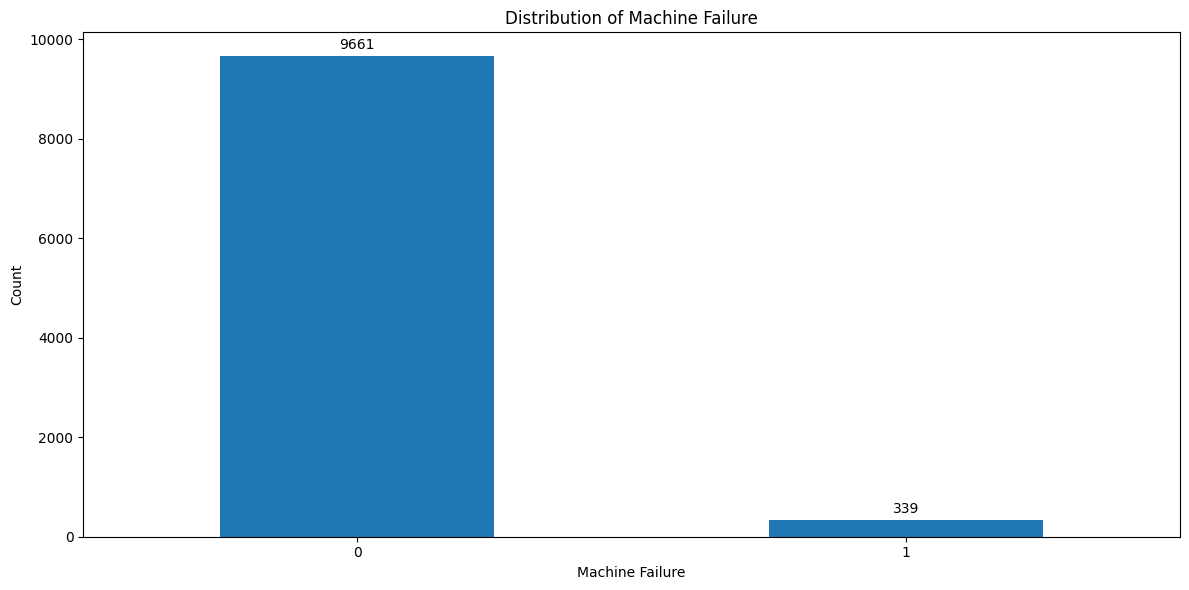

In [8]:
plt.figure(figsize=(12, 6))
counts = mill_df['Machine failure'].value_counts().sort_index()
ax = counts.plot(kind='bar')
plt.title('Distribution of Machine Failure')
plt.xticks(rotation=0)
plt.xlabel('Machine Failure')
plt.ylabel('Count')

# add data labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Type

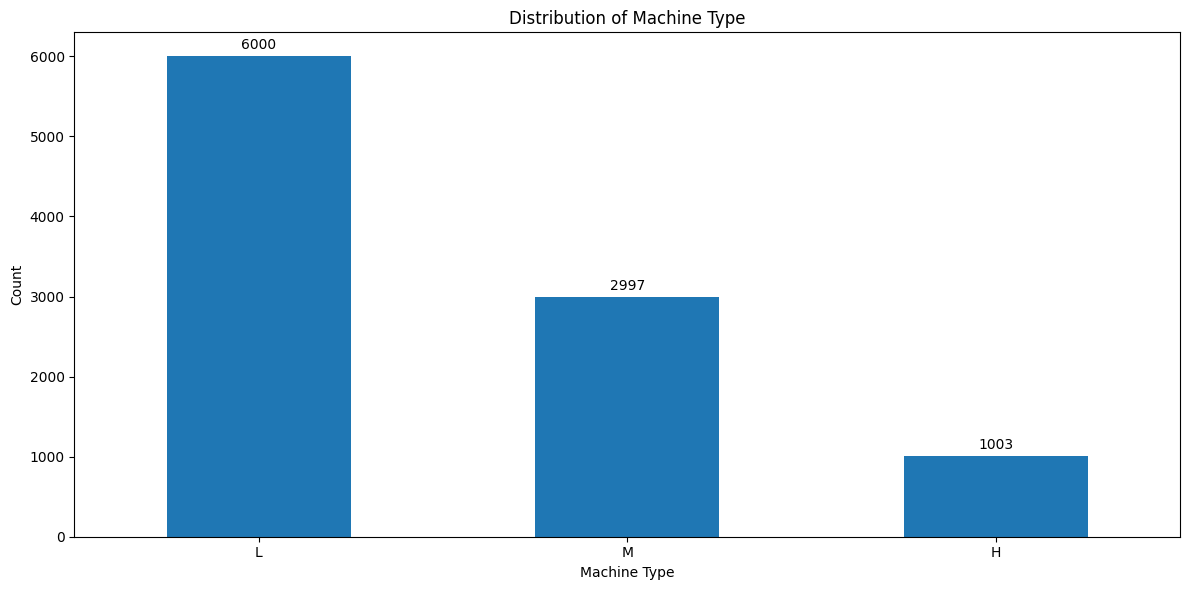

In [9]:
plt.figure(figsize=(12, 6))
# ensure consistent order L, M, H
counts = mill_df['Type'].value_counts().reindex(['L', 'M', 'H']).fillna(0).astype(int)
ax = counts.plot(kind='bar')
plt.title('Distribution of Machine Type')
plt.xticks(rotation=0)
plt.xlabel('Machine Type')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

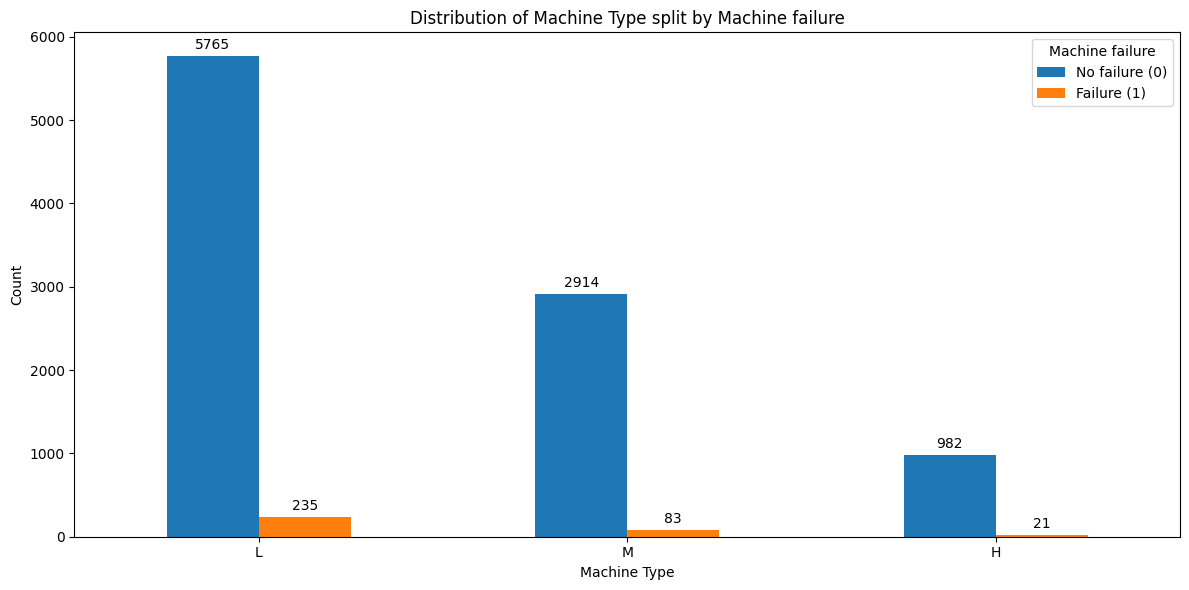

In [20]:
# distribution of Type split by Machine failure (0 = no failure, 1 = failure)
grp = mill_df.groupby(['Type', 'Machine failure']).size().unstack(fill_value=0).reindex(['L', 'M', 'H'])

ax2 = grp.plot(kind='bar', figsize=(12, 6), color=['C0', 'C1'])
plt.title('Distribution of Machine Type split by Machine failure')
plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Machine failure', labels=['No failure (0)', 'Failure (1)'])

# add data labels
for container in ax2.containers:
    ax2.bar_label(container, fmt='%d', padding=3)

plt.tight_layout()
plt.show()

C:\Users\Axel\AppData\Local\Temp\ipykernel_18580\1026394751.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Machine failure', y=feat, data=mill_df, ax=axs[i], palette=['C0', 'C1'])
C:\Users\Axel\AppData\Local\Temp\ipykernel_18580\1026394751.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(['No failure (0)', 'Failure (1)'])
C:\Users\Axel\AppData\Local\Temp\ipykernel_18580\1026394751.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Machine failure', y=feat, data=mill_df, ax=axs[i], palette=['C0', 'C1'])
C:\Users\Axel\AppData\Local\Temp\ipykernel_18580\1026394751.py:16

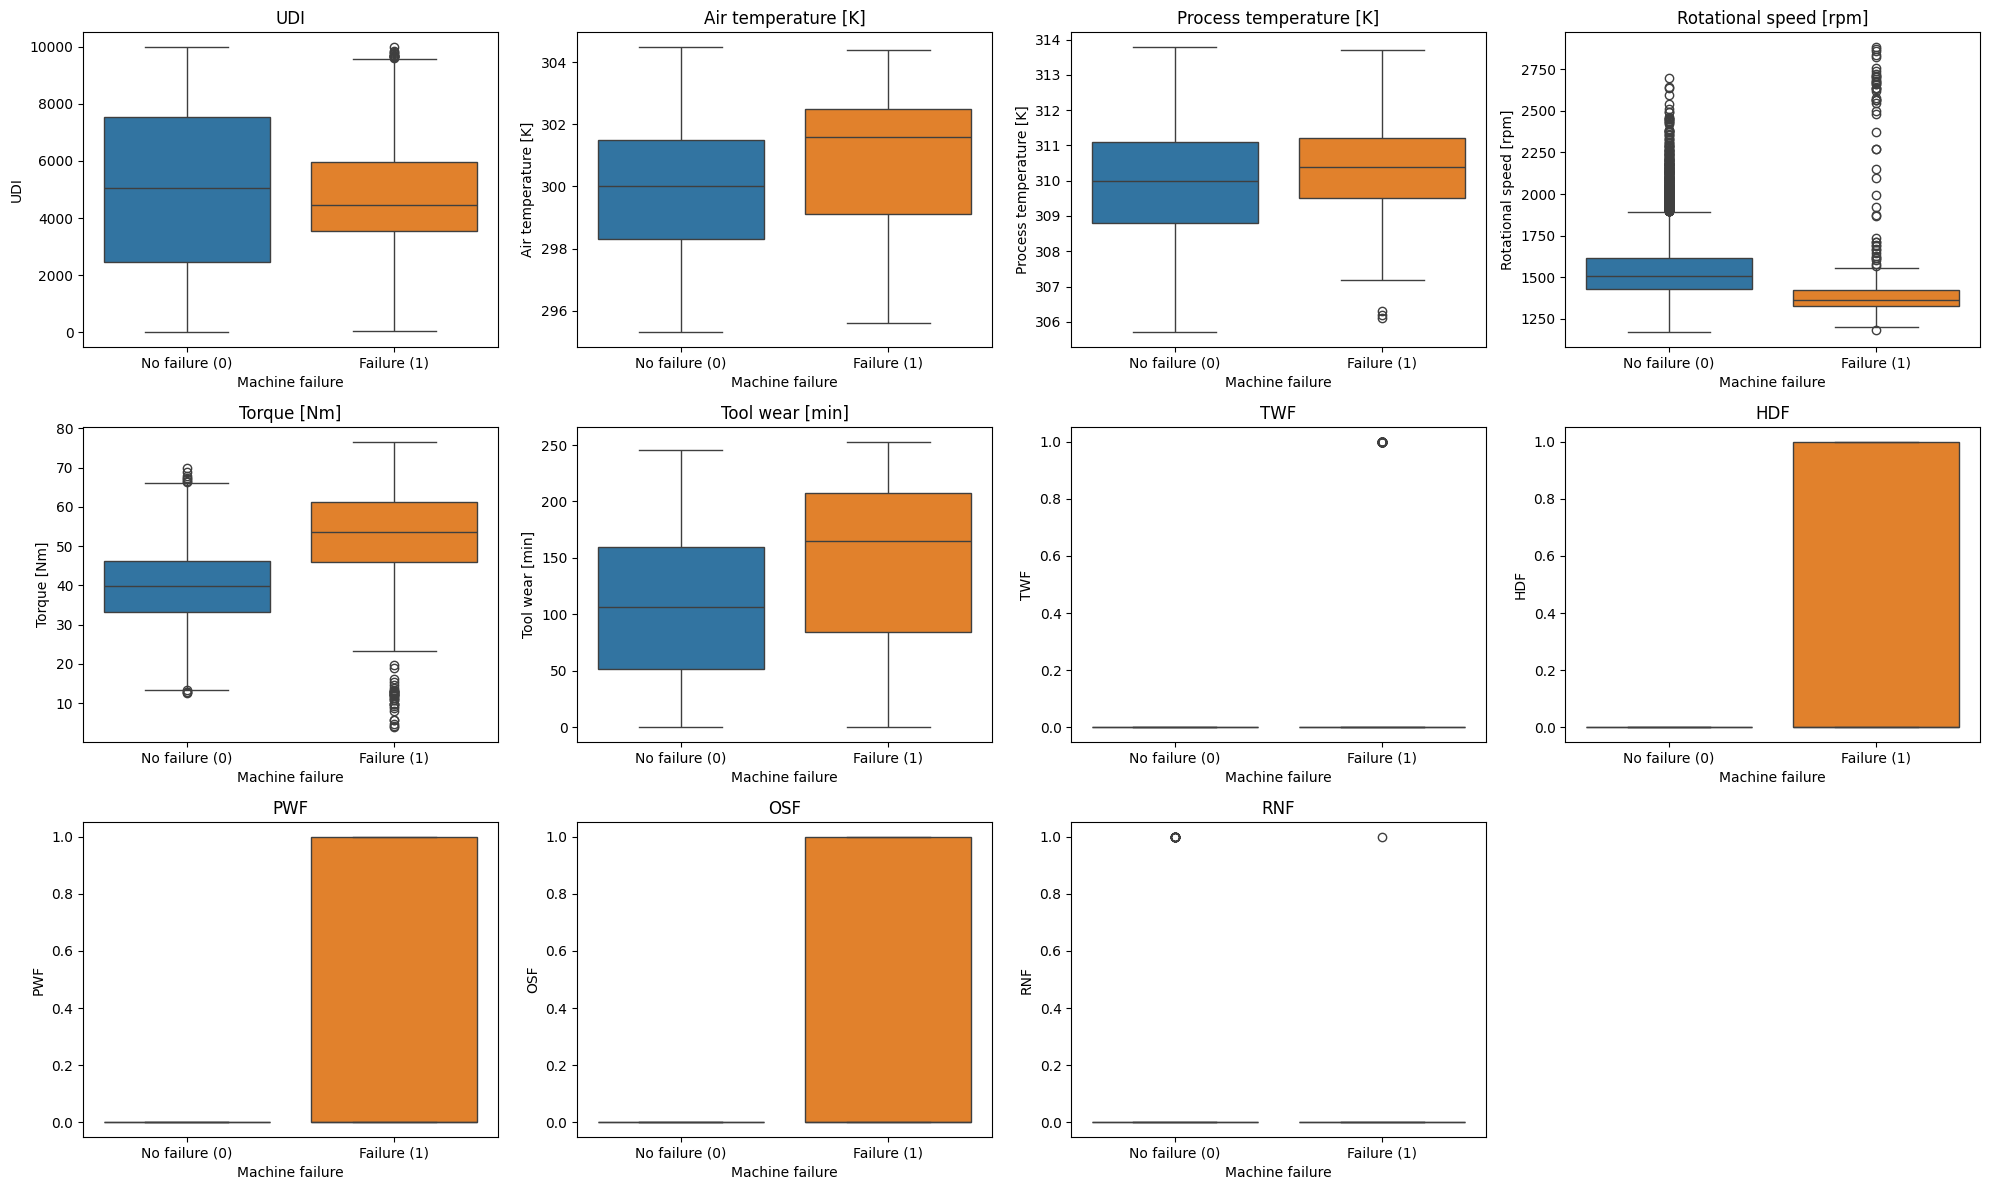

In [25]:
# Box plots for all numeric features split by Machine failure
numeric_cols = mill_df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != 'Machine failure']

n_features = len(features)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axs = axs.flatten()

for i, feat in enumerate(features):
    sns.boxplot(x='Machine failure', y=feat, data=mill_df, ax=axs[i], palette=['C0', 'C1'])
    axs[i].set_title(feat)
    axs[i].set_xlabel('Machine failure')
    axs[i].set_xticklabels(['No failure (0)', 'Failure (1)'])

# Turn off any unused subplots
for j in range(n_features, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

#### Air temperature [K]

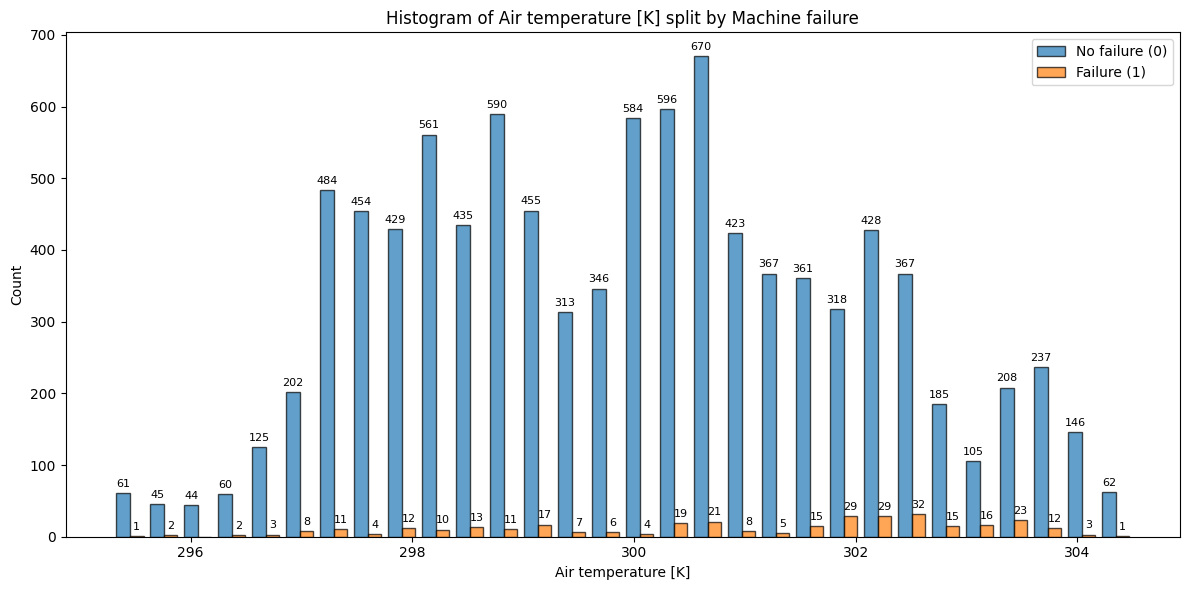

In [24]:
plt.figure(figsize=(12, 6))

# prepare bins and centers
bins = np.histogram_bin_edges(mill_df['Air temperature [K]'], bins=30)
bin_centers = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0]) * 0.4

colors = ['C0', 'C1']
labels = ['No failure (0)', 'Failure (1)']

for i, failure_state in enumerate([0, 1]):
    grp_data = mill_df.loc[mill_df['Machine failure'] == failure_state, 'Air temperature [K]']
    counts, _ = np.histogram(grp_data, bins=bins)
    x = bin_centers + (i - 0.5) * width  # offset so bars sit side-by-side
    plt.bar(x, counts, width=width, color=colors[i], edgecolor='black', alpha=0.7, label=labels[i])
    for xi, h in zip(x, counts):
        if h > 0:
            plt.annotate(f'{int(h)}', (xi, h), ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.title('Histogram of Air temperature [K] split by Machine failure')
plt.xlabel('Air temperature [K]')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


#### Process temperature [K]

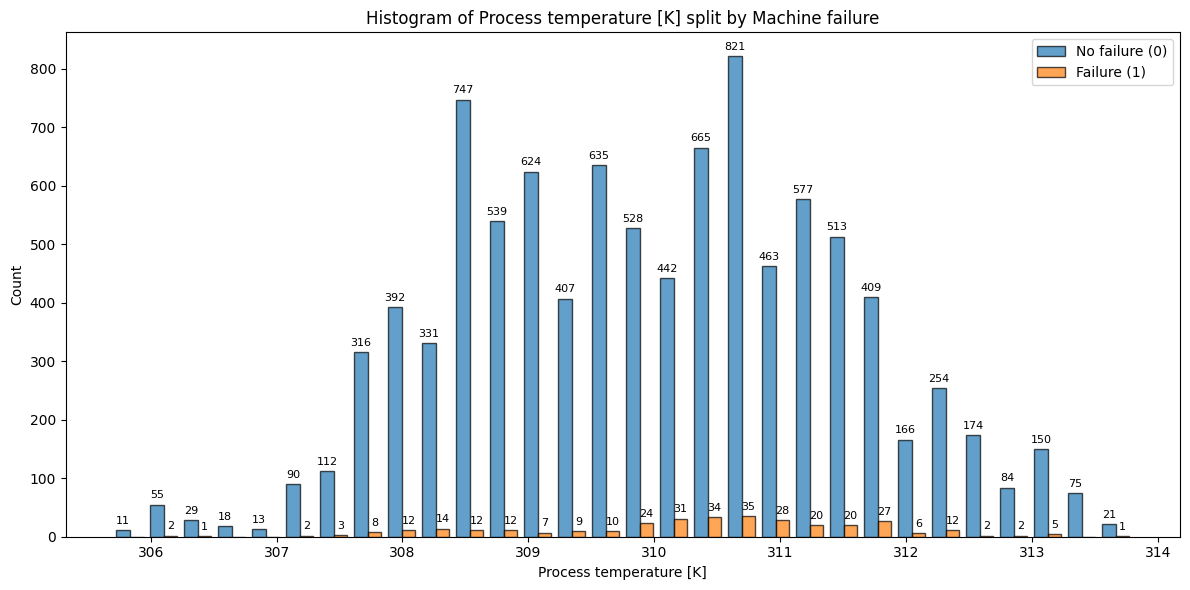

In [22]:
plt.figure(figsize=(12, 6))

# prepare bins and centers for Process temperature
bins_proc = np.histogram_bin_edges(mill_df['Process temperature [K]'], bins=30)
bin_centers_proc = (bins_proc[:-1] + bins_proc[1:]) / 2
width_proc = (bins_proc[1] - bins_proc[0]) * 0.4

colors = ['C0', 'C1']
labels = ['No failure (0)', 'Failure (1)']

for i, failure_state in enumerate([0, 1]):
    grp_data = mill_df.loc[mill_df['Machine failure'] == failure_state, 'Process temperature [K]']
    counts, _ = np.histogram(grp_data, bins=bins_proc)
    x = bin_centers_proc + (i - 0.5) * width_proc  # offset for side-by-side bars
    plt.bar(x, counts, width=width_proc, color=colors[i], edgecolor='black', alpha=0.7, label=labels[i])
    for xi, h in zip(x, counts):
        if h > 0:
            plt.annotate(f'{int(h)}', (xi, h), ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.title('Histogram of Process temperature [K] split by Machine failure')
plt.xlabel('Process temperature [K]')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


#### Rotational speed [rpm]

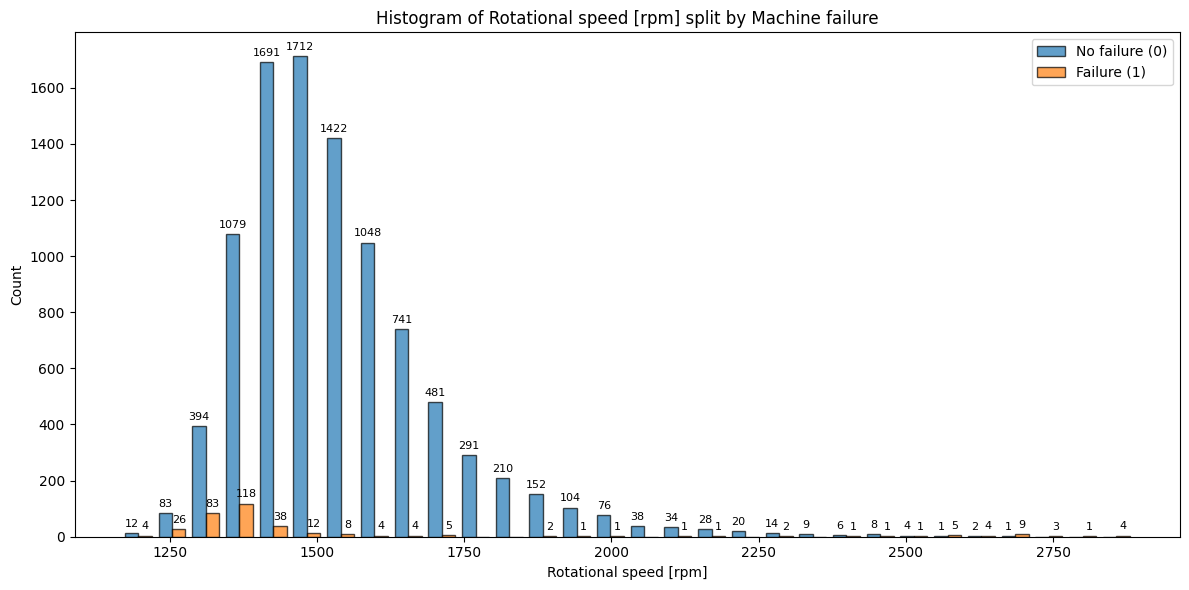

In [23]:
plt.figure(figsize=(12, 6))

# prepare bins and centers for Rotational speed
bins_rot = np.histogram_bin_edges(mill_df['Rotational speed [rpm]'], bins=30)
bin_centers_rot = (bins_rot[:-1] + bins_rot[1:]) / 2
width_rot = (bins_rot[1] - bins_rot[0]) * 0.4

for i, failure_state in enumerate([0, 1]):
    grp_data = mill_df.loc[mill_df['Machine failure'] == failure_state, 'Rotational speed [rpm]']
    counts, _ = np.histogram(grp_data, bins=bins_rot)
    x = bin_centers_rot + (i - 0.5) * width_rot  # offset for side-by-side bars
    plt.bar(x, counts, width=width_rot, color=colors[i], edgecolor='black', alpha=0.7, label=labels[i])
    for xi, h in zip(x, counts):
        if h > 0:
            plt.annotate(f'{int(h)}', (xi, h), ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontsize=8)

plt.title('Histogram of Rotational speed [rpm] split by Machine failure')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


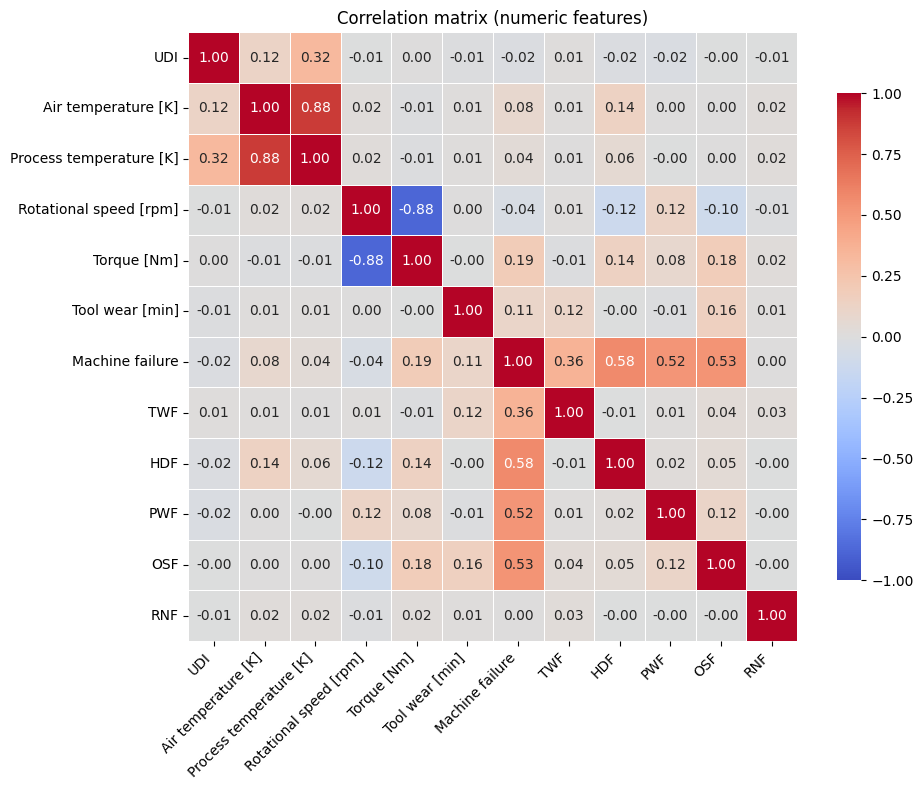

In [18]:
# compute correlation and plot heatmap
corr = mill_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation matrix (numeric features)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

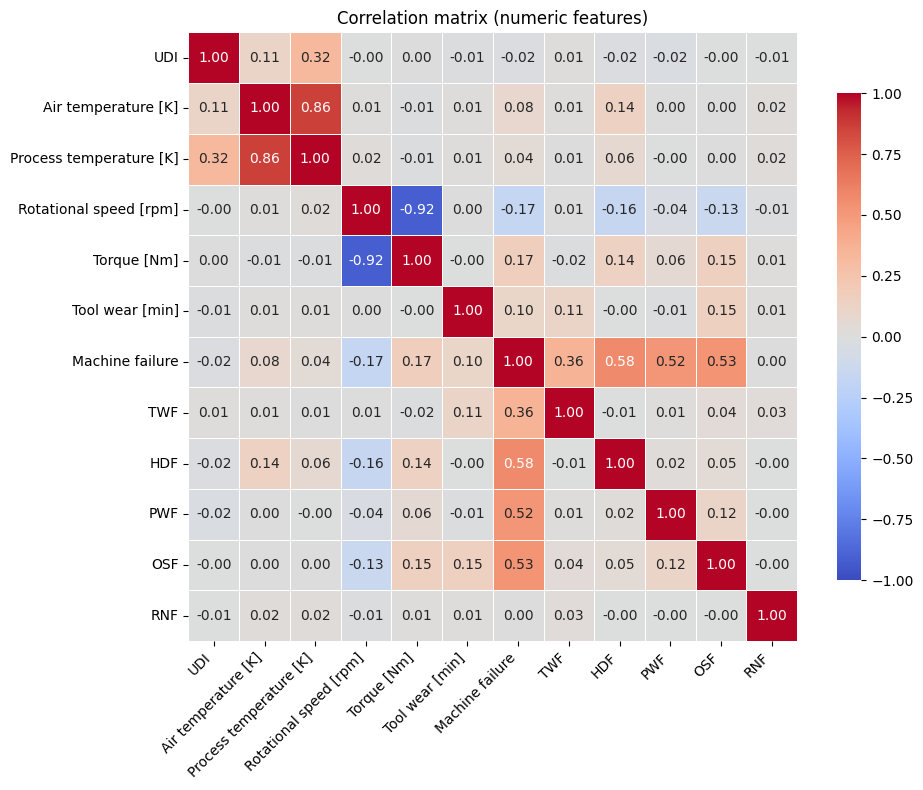

In [19]:
# compute correlation and plot heatmap
corr = mill_df.corr(numeric_only=True, method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation matrix (numeric features)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()